# Week 11 Problem 3

If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_  → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.
-----
# Problem 11.3. General Linear Models

In this problem, we will use a general linear model to fit a linear model that predicts `AirTime` from `Distance`. In the end, you'll be able to get a graph like this:
![](images/sample.png)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_is_instance, assert_true
from numpy.testing import assert_array_almost_equal, assert_almost_equal

We use the `2001/2001-1.csv`， which includes top 500,000 rows of `2001.csv`. For simplicity, we limit our analysis to flights that departed from Los Angeles International Airport (LAX), and use every 500th row.

In [2]:
filename = '/home/data_scientist/data/2001/2001-1.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'LAX'] # use only flights departed from LAX (Los Angeles)
local = local.dropna() # drop missing values
local = local.loc[::500] # use every 500th row

print(local.head())

       AirTime Origin  Distance
55790     55.0    LAX       370
64164     43.0    LAX       236
78314     56.0    LAX       337
89797     46.0    LAX       236
97817     67.0    LAX       337


## General Linear Model

- Estimate a Bayesian linear regression model using the `pymc3.glm.glm()` function.
- Assume that our data is distributed according to the normal distribution.
- Use a [Patsy](https://patsy.readthedocs.org/en/latest/formulas.html) string to describe the linear model. Name the independent variable `x` and the dependent variable `y`.
- Estimate the model paramters with the maximum a posteriori (MAP) method (using default paramters).
- Use the No-U-Turn Sampler (NUTS) to generate posterior samples (using default paramters).
- Use the `random_seed` parameter in `pymc3.sample()` method for reproducibility.

In [3]:
def sample_posterior(x, y, n_samples=1000, random_seed=0):
    '''
    A general linear model.
    
    Paramters
    ---------
    x: A numpy array
    y: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 1000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    # YOUR CODE HERE
    # DataFrame
    df = pd.DataFrame({'x': x, 'y': y})
    
    with pm.Model() as model_glm:
        pm.glm.glm('y ~ x', df, family = pm.glm.families.Normal()) # normal distribution
        
        # assumes a MAP starting point and NUTS sampler
        start = pm.find_MAP()
        step = pm.NUTS()
        trace = pm.sample(n_samples, step = step, start = start, 
                          progressbar = True, random_seed = random_seed)
        
    return trace

In [4]:
trace = sample_posterior(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Optimization terminated successfully.
         Current function value: 165.765865
         Iterations: 47
         Function evaluations: 54
         Gradient evaluations: 54


100%|██████████| 2000/2000 [00:18<00:00, 181.19it/s]


## Tests

In [5]:
assert_is_instance(trace, pm.backends.base.MultiTrace)

In [6]:
assert_true('Intercept' in trace.varnames)
assert_true('x' in trace.varnames)

In [7]:
for v in trace.varnames:
    assert_equal(len(trace[v]), 2000)

In [8]:
assert_almost_equal(trace['Intercept'][0], 20.163150232199225)
assert_almost_equal(trace['x'][0], 0.10362609694333563)

In [9]:
assert_array_almost_equal(
    trace['Intercept'][-5:],
    [ 20.444908,  20.444908,  20.128365,  21.166983,  21.201882]
    )
assert_array_almost_equal(
    trace['x'][-5:],
    [ 0.105146,  0.105146,  0.10482 ,  0.104374,  0.103111]
    )

## Visualization

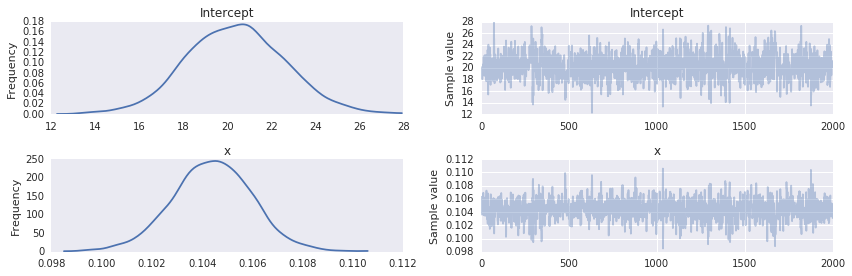

In [10]:
pm.traceplot(trace, ['Intercept', 'x']);

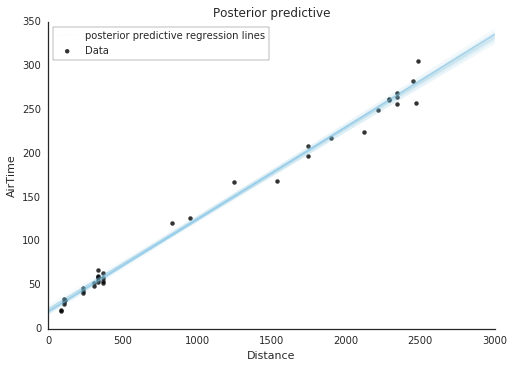

In [11]:
sns.set(style='white')

ax = sns.regplot(data=local, x='Distance', y='AirTime',
                 fit_reg=False, color='k', label="Data")

ax.set_xlim(0, 3000)
ax.set_ylim(0, 350)

x_sample = np.linspace(0, 3000, 2)

pm.glm.plot_posterior_predictive(trace, samples=100, eval=x_sample,
                                 label='posterior predictive regression lines', color='skyblue', alpha=0.2)
sns.despine()

ax.legend(loc='upper left', frameon=True)

plt.show()